# tdsm encoder
Here we provide interactive scripts, with which one can study input features, hyperparameters and finally perform the training & sampling of generative model. All of these scripts use classes and functions used in the code that runs on condor in order to obtain the optimised model trained on the full dataset. We advise not to train the model on the full dataset here as it will take too long. We advise to limit the training dataset size and number of epochs and use this notebook to study pre-processing, hyperparameters and diffusion techniques.

## import model

In [1]:
import time, functools, torch, os,sys, random, fnmatch, psutil
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam,RAdam
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import trans_tdsm, utils
from prettytable import PrettyTable
import util.dataset_structure, util.display, util.model
import tqdm
from IPython import display

device = 'cuda' if torch.cuda.is_available() else 'cpu'
padding_value = -20

dataset = "dataset_1_photons_padded_nentry"
dataset_store_path = "/eos/user/j/jthomasw/tdsm_encoder/datasets/power_transformer/"
transform = None
transform_y = None
mask = True
jupyternotebook = True

workingdir = "./"
### HYPERPARAMETERS ###
train_ratio = 0.8
batch_size = 64
lr = 0.00001
n_epochs = 50
### SDE PARAMETERS ###
SDE = 'VE'
sigma_max = 10.
### MODEL PARAMETERS ###
n_feat_dim = 4
embed_dim = 512
hidden_dim = 128
num_encoder_blocks = 3
num_attn_heads = 8
dropout_gen = 0

# Instantiate stochastic differential equation
if SDE == 'VP':
    sde = utils.VPSDE(beta_max=sigma_max,device=device)
if SDE == 'VE':
    sde = utils.VESDE(sigma_max=sigma_max,device=device)
marginal_prob_std_fn = functools.partial(sde.marginal_prob)
diffusion_coeff_fn = functools.partial(sde.sde)

print('torch version: ', torch.__version__)
print('Running on device: ', device)
if torch.cuda.is_available():
    print('Cuda used to build pyTorch: ',torch.version.cuda)
    print('Current device: ', torch.cuda.current_device())
    print('Cuda arch list: ', torch.cuda.get_arch_list())

print('Working directory: ', workingdir)

files_list_ = []
for filename in os.listdir(dataset_store_path):
    if fnmatch.fnmatch(filename, dataset + '12*.pt') or fnmatch.fnmatch(filename, dataset + '21*.pt') or fnmatch.fnmatch(filename, dataset + '30*.pt'):
    #if fnmatch.fnmatch(filename, dataset + '30*.pt'):
        files_list_.append(os.path.join(dataset_store_path, filename))
print(files_list_)

model=trans_tdsm.Gen(n_feat_dim, embed_dim, hidden_dim, num_encoder_blocks, num_attn_heads, dropout_gen, marginal_prob_std=marginal_prob_std_fn)

table = PrettyTable(['Module name', 'Parameters listed'])
t_params = 0
for name_ , para_ in model.named_parameters():
    if not para_.requires_grad: continue
    param = para_.numel()
    table.add_row([name_, param])
    t_params+=param
print(table)
print(f'Sum of trainable parameters: {t_params}')    

torch version:  1.11.0a0+gitbc2c6ed
Running on device:  cuda
Cuda used to build pyTorch:  11.2
Current device:  0
Cuda arch list:  ['sm_37', 'sm_50', 'sm_60', 'sm_61', 'sm_70', 'sm_75', 'compute_37']
Working directory:  ./
['/eos/user/j/jthomasw/tdsm_encoder/datasets/power_transformer/dataset_1_photons_padded_nentry121To150.pt', '/eos/user/j/jthomasw/tdsm_encoder/datasets/power_transformer/dataset_1_photons_padded_nentry211To240.pt', '/eos/user/j/jthomasw/tdsm_encoder/datasets/power_transformer/dataset_1_photons_padded_nentry301To330.pt']
+--------------------------------+-------------------+
|          Module name           | Parameters listed |
+--------------------------------+-------------------+
|           cls_token            |        512        |
|          embed.weight          |        2048       |
|           embed.bias           |        512        |
|        embed_t.1.weight        |       262144      |
|         embed_t.1.bias         |        512        |
|      dense1.d

## Plot data distribution

We display distributions of either the transformed or non-transformed input features, however the training is always performed using the transformed inputs where available. The `energy_trans_file` argument should be the pickle file containing fitted input transformation function. Only provide a file name if you want to plot distributions where the transformation has been inverted and applied to inputs to transform back to the original distributions. In such cases, if you want to check the inverted transformation is doing the correct inversion, compare for a single file against the plots inside the directory:

`
datasets/<transformation>/featureplots_dataset
`

Plots of the inverted transformation should be similar to what is shown in those, though not identical as we only plot a subset of the showers.

plot_distribution running on input type 'files'
n_files <class 'int'>: 3
nshowers_2_plot <class 'int'>: 1000
File: /eos/user/j/jthomasw/tdsm_encoder/datasets/power_transformer/dataset_1_photons_padded_nentry121To150.pt
# batches: 14635
File: /eos/user/j/jthomasw/tdsm_encoder/datasets/power_transformer/dataset_1_photons_padded_nentry211To240.pt
# batches: 8917
File: /eos/user/j/jthomasw/tdsm_encoder/datasets/power_transformer/dataset_1_photons_padded_nentry301To330.pt
# batches: 28518
Plot # entries
Plot incident energies
Plot total deposited hit energy
Plot hit x
Plot hit energies
Plot hit y
Plot hit z


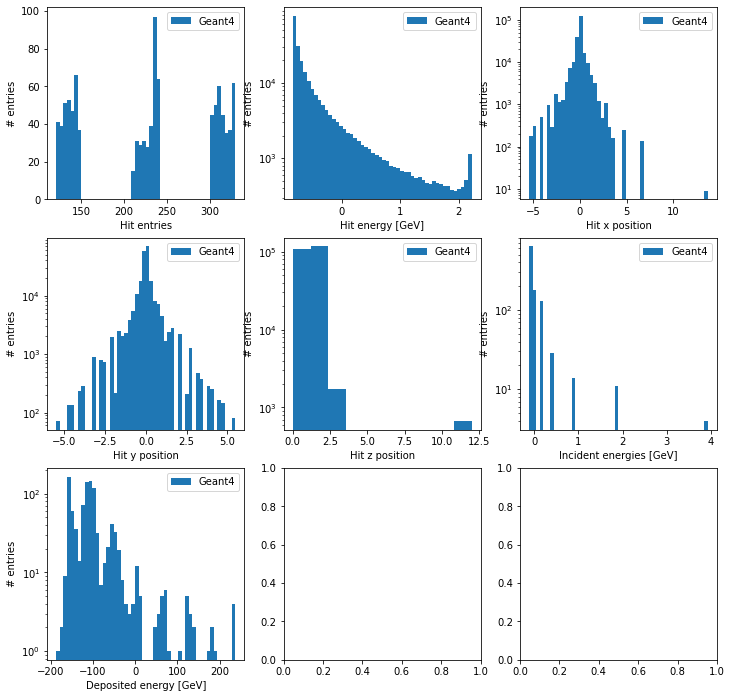

In [4]:
#dists = util.display.plot_distribution(files_list_,energy_trans_file='transform_e.pkl')
dists = util.display.plot_distribution(files_list_)

entries = dists[0]
all_incident_e = dists[1]
total_deposited_e_shower = dists[2]
all_e = dists[3]
all_x = dists[4]
all_y = dists[5]
all_z = dists[6]

fig, ax = plt.subplots(3,3, figsize=(12,12))
print('Plot # entries')
ax[0][0].set_ylabel('# entries')
ax[0][0].set_xlabel('Hit entries')
ax[0][0].hist(entries, 50, label='Geant4')
ax[0][0].legend(loc='upper right')

print('Plot incident energies')
ax[1][2].set_ylabel('# entries')
ax[1][2].set_xlabel('Incident energies [GeV]')
ax[1][2].hist(all_incident_e, 50, label='Geant4')
ax[1][2].set_yscale('log')
ax[1][2].legend(loc='upper right')

print('Plot total deposited hit energy')
ax[2][0].set_ylabel('# entries')
ax[2][0].set_xlabel('Deposited energy [GeV]')
ax[2][0].hist(total_deposited_e_shower, 50, label='Geant4')
ax[2][0].set_yscale('log')
ax[2][0].legend(loc='upper right')

print('Plot hit x')
ax[0][2].set_ylabel('# entries')
ax[0][2].set_xlabel('Hit x position')
ax[0][2].hist(all_x, 50, label='Geant4')
ax[0][2].set_yscale('log')
ax[0][2].legend(loc='upper right')

print('Plot hit energies')
ax[0][1].set_ylabel('# entries')
ax[0][1].set_xlabel('Hit energy [GeV]')
ax[0][1].hist(all_e, 50, label='Geant4')
ax[0][1].set_yscale('log')
ax[0][1].legend(loc='upper right')

print('Plot hit y')
ax[1][0].set_ylabel('# entries')
ax[1][0].set_xlabel('Hit y position')
ax[1][0].hist(all_y, 50, label='Geant4')
ax[1][0].set_yscale('log')
ax[1][0].legend(loc='upper right')

print('Plot hit z')
ax[1][1].set_ylabel('# entries')
ax[1][1].set_xlabel('Hit z position')
ax[1][1].hist(all_z, label='Geant4')
ax[1][1].set_yscale('log')
ax[1][1].legend(loc='upper right')

fig.show()
save_name = os.path.join(dataset_store_path,'input_dists_transformed.png')
fig.savefig(save_name)

## Training

Training is performed now on the transformed input features, therefore the generated samples will also be in the transformed feature space

  0%|          | 0/50 [00:00<?, ?it/s]

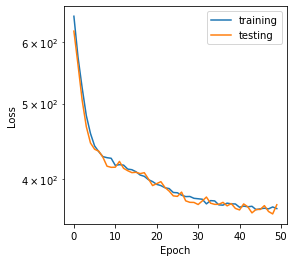

['/eos/user/j/jthomasw/tdsm_encoder/datasets/power_transformer/dataset_1_photons_padded_nentry121To150.pt', '/eos/user/j/jthomasw/tdsm_encoder/datasets/power_transformer/dataset_1_photons_padded_nentry211To240.pt', '/eos/user/j/jthomasw/tdsm_encoder/datasets/power_transformer/dataset_1_photons_padded_nentry301To330.pt']


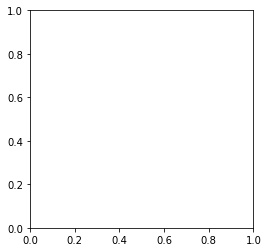

In [2]:
output_directory = workingdir+'/training_'+datetime.now().strftime('%Y%m%d_%H%M')+'_output/'
if not os.path.exists(output_directory):
            os.makedirs(output_directory)
optimiser = RAdam(model.parameters(),lr=lr)
av_training_losses_per_epoch = []
av_testing_losses_per_epoch = []

fig, ax = plt.subplots(ncols=1, figsize=(4,4))
epochs = tqdm.notebook.trange(n_epochs)
dh = display.display(fig, display_id=True)

print(files_list_)

for epoch in epochs:

    # Create/clear per epoch variables
    cumulative_epoch_loss = 0.
    cumulative_test_epoch_loss = 0.

    file_counter = 0
    n_training_showers = 0
    n_testing_showers = 0
    training_batches_per_epoch = 0
    testing_batches_per_epoch = 0

    # Load files
    for filename in files_list_:
        custom_data = utils.cloud_dataset(filename, device=device)
        train_size = int(train_ratio * len(custom_data.data))
        test_size = len(custom_data.data) - train_size
        train_dataset, test_dataset = torch.utils.data.random_split(custom_data, [train_size, test_size])

        n_training_showers+=train_size
        n_testing_showers+=test_size
        # Load clouds for each epoch of data dataloaders length will be the number of batches
        shower_loader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        shower_loader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
        
        # Accumuate number of batches per epoch
        training_batches_per_epoch += len(shower_loader_train)
        testing_batches_per_epoch += len(shower_loader_test)
        
        # Load shower batch for training
        for i, (shower_data,incident_energies) in enumerate(shower_loader_train,0):
            # Move model to device and set dtype as same as data (note torch.double works on both CPU and GPU)
            model.to(device, shower_data.dtype)
            model.train()
            shower_data = shower_data.to(device)
            incident_energies = incident_energies.to(device)
            
            if len(shower_data) < 1:
                print('Very few hits in shower: ', len(shower_data))
                continue
            # Zero any gradients from previous steps
            optimiser.zero_grad()
            # Loss average for each batch
            loss = trans_tdsm.loss_fn(model, shower_data, incident_energies, marginal_prob_std_fn, device=device)
            # Accumulate batch loss per epoch
            cumulative_epoch_loss+=float(loss)
            # collect dL/dx for any parameters (x) which have requires_grad = True via: x.grad += dL/dx
            #loss.backward(retain_graph=True)
            loss.backward()
            # Update value of x += -lr * x.grad
            optimiser.step()
            
        # Testing on subset of file
        for i, (shower_data,incident_energies) in enumerate(shower_loader_test,0):
            with torch.no_grad():
                model.eval()
                shower_data = shower_data.to(device)
                incident_energies = incident_energies.to(device)
                test_loss = trans_tdsm.loss_fn(model, shower_data, incident_energies, marginal_prob_std_fn, device=device)
                cumulative_test_epoch_loss+=float(test_loss)
    
    # Calculate average loss per epoch
    av_training_losses_per_epoch.append(cumulative_epoch_loss/training_batches_per_epoch)
    av_testing_losses_per_epoch.append(cumulative_test_epoch_loss/testing_batches_per_epoch)
    epochs.set_description('Average Loss: {:5f}(Train) {:5f}(Test)'.format(cumulative_epoch_loss/training_batches_per_epoch, cumulative_test_epoch_loss/testing_batches_per_epoch))
    fig, ax = plt.subplots(ncols=1, figsize=(4,4))
    plt.title('')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.yscale('log')
    plt.plot(av_training_losses_per_epoch, label='training')
    plt.plot(av_testing_losses_per_epoch, label='testing')
    plt.legend(loc='upper right')
    dh.update(fig)
    if epoch == n_epochs:
        fig.savefig(output_directory+'loss_v_epoch.png')
    plt.close(fig)

torch.save(model.state_dict(), output_directory+'ckpt_tmp_'+str(epoch)+'.pth')


## Sampling 

batch_size: 64
Files: ['/eos/user/j/jthomasw/tdsm_encoder/datasets/power_transformer/dataset_1_photons_padded_nentry121To150.pt', '/eos/user/j/jthomasw/tdsm_encoder/datasets/power_transformer/dataset_1_photons_padded_nentry211To240.pt', '/eos/user/j/jthomasw/tdsm_encoder/datasets/power_transformer/dataset_1_photons_padded_nentry301To330.pt']


/eos/home-i01/j/jthomasw/tdsm_encoder/trans_tdsm.py:430: RuntimeWarning:

invalid value encountered in true_divide



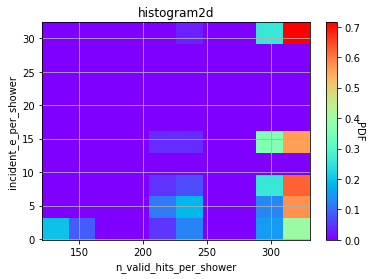

# batches: 79
Generation batch 0: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 1/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([64, 310, 4])
Generation batch 1: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 2/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([128, 310, 4])
Generation batch 2: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 3/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([192, 310, 4])
Generation batch 3: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 4/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([256, 310, 4])
Generation batch 4: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 5/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([320, 310, 4])
Generation batch 5: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 6/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([384, 310, 4])
Generation batch 6: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 7/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([448, 310, 4])
Generation batch 7: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 8/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([512, 310, 4])
Generation batch 8: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 9/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([576, 310, 4])
Generation batch 9: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 10/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([640, 310, 4])
Generation batch 10: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 11/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([704, 310, 4])
Generation batch 11: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 12/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([768, 310, 4])
Generation batch 12: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 13/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([832, 310, 4])
Generation batch 13: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 14/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([896, 310, 4])
Generation batch 14: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 15/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([960, 310, 4])
Generation batch 15: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 16/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([1024, 310, 4])
Generation batch 16: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 17/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([1088, 310, 4])
Generation batch 17: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 18/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([1152, 310, 4])
Generation batch 18: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 19/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([1216, 310, 4])
Generation batch 19: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 20/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([1280, 310, 4])
Generation batch 20: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 21/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([1344, 310, 4])
Generation batch 21: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 22/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([1408, 310, 4])
Generation batch 22: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 23/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([1472, 310, 4])
Generation batch 23: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 24/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([1536, 310, 4])
Generation batch 24: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 25/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([1600, 310, 4])
Generation batch 25: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 26/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([1664, 310, 4])
Generation batch 26: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 27/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([1728, 310, 4])
Generation batch 27: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 28/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([2112, 310, 4])
Generation batch 33: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 34/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([2176, 310, 4])
Generation batch 34: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 35/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([2240, 310, 4])
Generation batch 35: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 36/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([2304, 310, 4])
Generation batch 36: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 37/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([2368, 310, 4])
Generation batch 37: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 38/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([2432, 310, 4])
Generation batch 38: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 39/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([2496, 310, 4])
Generation batch 39: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 40/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([2560, 310, 4])
Generation batch 40: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 41/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([2624, 310, 4])
Generation batch 41: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 42/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([2688, 310, 4])
Generation batch 42: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 43/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([2752, 310, 4])
Generation batch 43: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 44/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([2816, 310, 4])
Generation batch 44: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 45/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([2880, 310, 4])
Generation batch 45: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 46/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([2944, 310, 4])
Generation batch 46: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 47/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([3008, 310, 4])
Generation batch 47: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 48/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([3072, 310, 4])
Generation batch 48: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 49/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([3136, 310, 4])
Generation batch 49: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 50/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([3200, 310, 4])
Generation batch 50: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 51/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([3264, 310, 4])
Generation batch 51: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 52/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([3328, 310, 4])
Generation batch 52: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 53/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([3392, 310, 4])
Generation batch 53: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 54/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([3456, 310, 4])
Generation batch 54: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 55/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([3520, 310, 4])
Generation batch 55: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 56/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([3584, 310, 4])
Generation batch 56: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 57/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([3648, 310, 4])
Generation batch 57: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 58/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([3712, 310, 4])
Generation batch 58: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 59/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([3776, 310, 4])
Generation batch 59: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 60/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([3840, 310, 4])
Generation batch 60: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 61/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([3904, 310, 4])
Generation batch 61: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 62/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([3968, 310, 4])
Generation batch 62: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 63/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([4032, 310, 4])
Generation batch 63: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 64/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([4096, 310, 4])
Generation batch 64: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 65/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([4160, 310, 4])
Generation batch 65: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 66/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([4224, 310, 4])
Generation batch 66: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 67/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([4288, 310, 4])
Generation batch 67: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 68/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([4352, 310, 4])
Generation batch 68: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 69/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([4416, 310, 4])
Generation batch 69: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 70/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([4480, 310, 4])
Generation batch 70: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 71/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([4544, 310, 4])
Generation batch 71: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 72/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([4608, 310, 4])
Generation batch 72: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 73/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([4672, 310, 4])
Generation batch 73: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 74/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([4736, 310, 4])
Generation batch 74: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 75/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([4800, 310, 4])
Generation batch 75: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 76/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([4864, 310, 4])
Generation batch 76: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 77/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([4928, 310, 4])
Generation batch 77: showers per batch: 64, max. hits per shower: 310, features per hit: 4, sampled_energies: 64
Progress: 78/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([4992, 310, 4])
Generation batch 78: showers per batch: 8, max. hits per shower: 310, features per hit: 4, sampled_energies: 8
Progress: 79/79

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([5000, 310, 4])


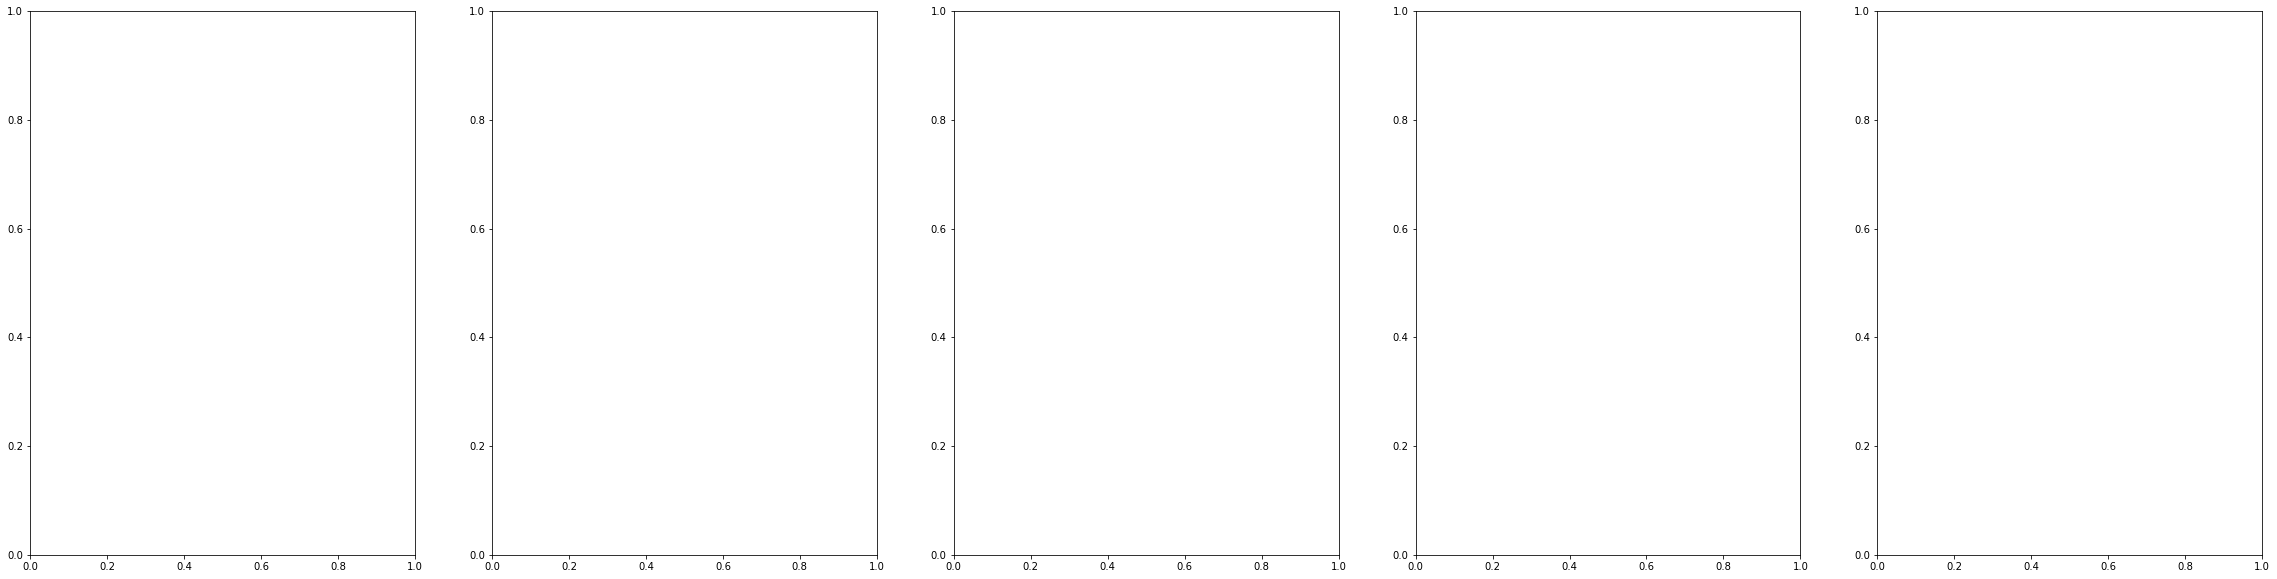

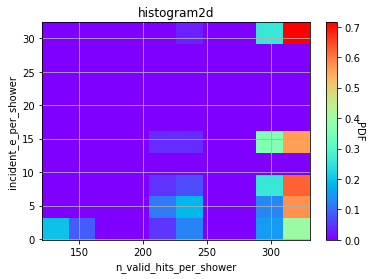

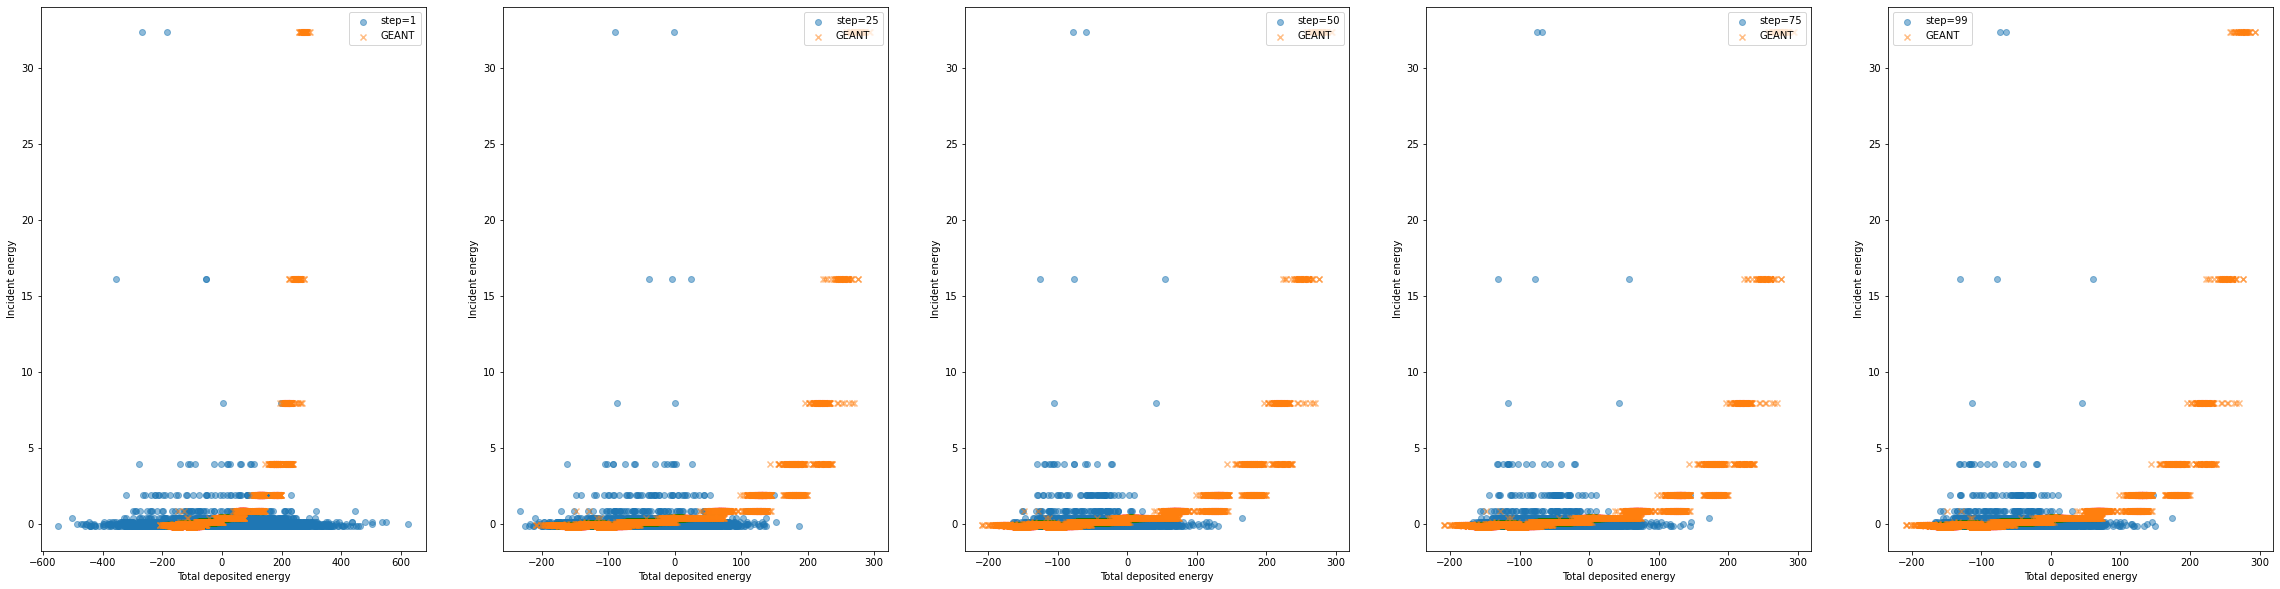

In [3]:
from IPython import display
from datetime import datetime
import functools, torch, os, sys, random
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import tqdm
workingdir = "./"

# SAMPLE PARAMETERS
n_sampler_calls = 100
sampler_steps = 100

print(f'batch_size: {batch_size}')

output_directory = workingdir+'/sampling_'+str(sampler_steps)+'samplersteps_'+datetime.now().strftime('%Y%m%d_%H%M')+'_output/'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Load saved model
model.load_state_dict(torch.load('training_20230718_1401_output/ckpt_tmp_49.pth', map_location=device))
model.to(device)

# Get max. N hits / N valid hits in batch
n_valid_hits_per_shower = []
incident_e_per_shower = []
geant_deposited_energy = []
max_hits = -1
print(f'Files: {files_list_}')
for file in files_list_:
    # Load shower data
    custom_data = utils.cloud_dataset(file, device=device)
    point_clouds_loader = DataLoader(custom_data, batch_size=batch_size, shuffle=False)
    # Loop over batches
    for i, (shower_data, incident_energies) in enumerate(point_clouds_loader,0):

        # Copy data
        valid_event = []
        data_np = shower_data.cpu().numpy().copy()
        energy_np = incident_energies.cpu().numpy().copy()

        # Mask for padded values
        masking = data_np[:,:,0] != -20
        
        # Loop over each shower in batch
        for j in range(len(data_np)):
            # Mask padded hits and count valid hits for shower j in batch
            valid_hits = data_np[j][masking[j]]
            n_valid_hits_per_shower.append(len(valid_hits))
            if len(valid_hits)>max_hits:
                max_hits = len(valid_hits)
            incident_e_per_shower.append(energy_np[j])
            geant_deposited_energy.append( sum( valid_hits[:,0] ) )
    del custom_data
    
# Arrays of Nvalid hits in showers, incident energies per shower
n_valid_hits_per_shower = np.array(n_valid_hits_per_shower)
incident_e_per_shower = np.array(incident_e_per_shower)
max_incident_e = max(incident_e_per_shower)
min_incident_e = min(incident_e_per_shower)

# Generate 2D pdf of incident E vs N valid hits from the training file(s)
n_bins_prob_dist = 10
e_vs_nhits_prob, x_bin, y_bin = trans_tdsm.get_prob_dist(incident_e_per_shower, n_valid_hits_per_shower, n_bins_prob_dist)

# Plot 2D histogram (sanity check)
fig0, (ax0) = plt.subplots(ncols=1, sharey=True)
dh0 = display.display(fig0, display_id=True)
heatmap = ax0.pcolormesh(y_bin, x_bin, e_vs_nhits_prob, cmap='rainbow')
ax0.plot(n_valid_hits_per_shower, n_valid_hits_per_shower, 'k-')
ax0.set_xlim(n_valid_hits_per_shower.min(), n_valid_hits_per_shower.max())
ax0.set_ylim(incident_e_per_shower.min(), incident_e_per_shower.max())
ax0.set_xlabel('n_valid_hits_per_shower')
ax0.set_ylabel('incident_e_per_shower')
cbar = plt.colorbar(heatmap)
cbar.ax.set_ylabel('PDF', rotation=270)
ax0.set_title('histogram2d')
ax0.grid()
dh0.update(fig0)

# Generate tensor sampled from the appropriate range of injection energies
n_showers_2_gen =  5000
idx_list_incident_e = torch.randint(0, len(incident_e_per_shower), (n_showers_2_gen,))
in_energies = np.random.choice( incident_e_per_shower, n_showers_2_gen )
in_energies = torch.from_numpy(in_energies)

# Sample from 2D pdf = nhits per shower vs incident energies -> nhits and a tensor of randomly initialised hit features
nhits, gen_hits = trans_tdsm.generate_hits(e_vs_nhits_prob, x_bin, y_bin, in_energies, max_hits, 4, device=device)

# Save
torch.save([gen_hits, in_energies],'tmp.pt')

# Load the showers of noise
gen_hits = utils.cloud_dataset('tmp.pt', device=device)
# Pad showers
gen_hits.padding(padding_value)
# Load len(gen_hits_loader) number of batches each with batch_size number of showers
gen_hits_loader = DataLoader(gen_hits, batch_size=batch_size, shuffle=False)

# Remove noise shower file
os.system("rm tmp.pt")

# Instantiate sampler
sample = []
pc_sampler = trans_tdsm.pc_sampler(snr=0.16, sampler_steps=sampler_steps, device=device, jupyternotebook=True)

# Loop over each batch of noise showers
print(f'# batches: {len(gen_hits_loader)}' )
for i, (gen_hit, sampled_energies) in enumerate(gen_hits_loader,0):
    
    print(f'Generation batch {i}: showers per batch: {gen_hit.shape[0]}, max. hits per shower: {gen_hit.shape[1]}, features per hit: {gen_hit.shape[2]}, sampled_energies: {len(sampled_energies)}')    
    sys.stdout.write('\r')
    sys.stdout.write("Progress: %d/%d" % ((i+1), len(gen_hits_loader)))
    sys.stdout.flush()
    
    # Run reverse diffusion sampler
    generative = pc_sampler(model, marginal_prob_std_fn, diffusion_coeff_fn, sampled_energies, gen_hit, batch_size=gen_hit.shape[0])
    
    # Create first sample or concatenate sample to sample list
    if i == 0:
        sample = generative
    else:
        sample = torch.cat([sample,generative])
    
    print(f'sample: {sample.shape}')

# Create plots of distributions evolving with diffusion steps
if jupyternotebook:
    fig1, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(nrows=1,ncols=5,figsize=(40,10))
    dh = display.display(fig1, display_id=True)

    label_tmp = 'step=1'
    ax1.scatter(pc_sampler.deposited_energy_t1 , pc_sampler.incident_e_t1, alpha=0.5, label=label_tmp)
    ax1.scatter(geant_deposited_energy, incident_e_per_shower, marker='x', alpha=0.5, label='GEANT')
    ax1.set_xlabel('Total deposited energy')
    ax1.set_ylabel('Incident energy')
    ax1.legend(loc='upper right')
    
    label_tmp = 'step=25'
    ax2.scatter(pc_sampler.deposited_energy_t25 , pc_sampler.incident_e_t25, alpha=0.5, label=label_tmp)
    ax2.scatter(geant_deposited_energy, incident_e_per_shower, marker='x', alpha=0.5, label='GEANT')
    ax2.set_xlabel('Total deposited energy')
    ax2.set_ylabel('Incident energy')
    ax2.legend(loc='upper right')
    
    label_tmp = 'step=50'
    ax3.scatter(pc_sampler.deposited_energy_t50 , pc_sampler.incident_e_t50, alpha=0.5, label=label_tmp)
    ax3.scatter(geant_deposited_energy, incident_e_per_shower, marker='x', alpha=0.5, label='GEANT')
    ax3.set_xlabel('Total deposited energy')
    ax3.set_ylabel('Incident energy')
    ax3.legend(loc='upper right')
    
    label_tmp = 'step=75'
    ax4.scatter(pc_sampler.deposited_energy_t75 , pc_sampler.incident_e_t75, alpha=0.5, label=label_tmp)
    ax4.scatter(geant_deposited_energy, incident_e_per_shower, marker='x', alpha=0.5, label='GEANT')
    ax4.set_xlabel('Total deposited energy')
    ax4.set_ylabel('Incident energy')
    ax4.legend(loc='upper right')
    
    label_tmp = 'step=99'
    ax5.scatter(pc_sampler.deposited_energy_t99 , pc_sampler.incident_e_t99, alpha=0.5, label=label_tmp)
    ax5.scatter(geant_deposited_energy, incident_e_per_shower, marker='x', alpha=0.5, label='GEANT')
    ax5.set_xlabel('Total deposited energy')
    ax5.set_ylabel('Incident energy')
    ax5.legend(loc='upper left')
    
    fig_name = os.path.join(output_directory, 'incident_v_deposited_e.png')
    fig1.savefig(fig_name)

    
sample_ = []
sample_np = sample.cpu().numpy()

for i in range(len(sample_np)):
    tmp_sample = sample_np[i][:nhits[i]]
    sample_.append(torch.tensor(tmp_sample))
torch.save([sample_,in_energies], os.path.join(output_directory, 'sample.pt'))


## Draw Generative Distribution

Generated inputs
plot_distribution running on input type 'cloud_dataset'
Geant4 inputs
plot_distribution running on input type 'files'
n_files <class 'int'>: 3
nshowers_2_plot <class 'int'>: 5000
File: /eos/user/j/jthomasw/tdsm_encoder/datasets/power_transformer/dataset_1_photons_padded_nentry121To150.pt
# batches: 14635
File: /eos/user/j/jthomasw/tdsm_encoder/datasets/power_transformer/dataset_1_photons_padded_nentry211To240.pt
# batches: 8917
File: /eos/user/j/jthomasw/tdsm_encoder/datasets/power_transformer/dataset_1_photons_padded_nentry301To330.pt
# batches: 28518
Plot # entries
Plot incident energies
Plot total deposited hit energy
Plot hit energies
Plot hit x
Plot hit y
Plot hit z


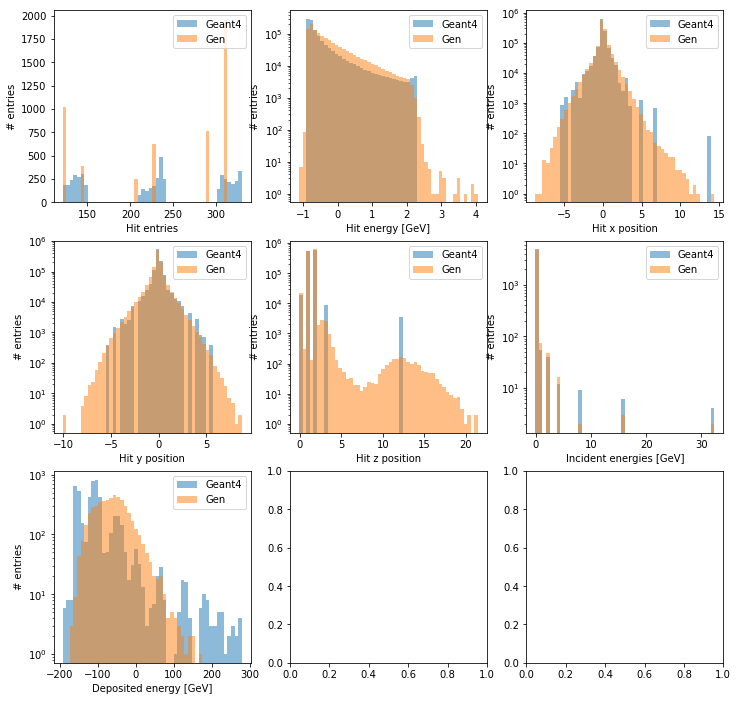

In [5]:
import utils, sys
#sys.path.insert(1, '../')
import util.display

# Distributions object for generated files
print(f'Generated inputs')
output_directory = 'sampling_100samplersteps_20230718_1604_output'
plot_file_name = os.path.join(output_directory, 'sample.pt')
custom_data = utils.cloud_dataset(plot_file_name,device=device)
dists_gen = util.display.plot_distribution(custom_data, nshowers_2_plot=n_showers_2_gen)

print(f'Geant4 inputs')
# Distributions object for Geant4 files
dists = util.display.plot_distribution(files_list_, nshowers_2_plot=n_showers_2_gen)

print('Plot # entries')
entries = dists[0]
entries_gen = dists_gen[0]
bins=np.histogram(np.hstack((entries,entries_gen)), bins=50)[1]
fig, ax = plt.subplots(3,3, figsize=(12,12))
ax[0][0].set_ylabel('# entries')
ax[0][0].set_xlabel('Hit entries')
ax[0][0].hist(entries, bins, alpha=0.5, label='Geant4')
ax[0][0].hist(entries_gen, bins, alpha=0.5, label='Gen')
ax[0][0].legend(loc='upper right')

print('Plot incident energies')
all_incident_e = dists[1]
all_incident_e_gen = dists_gen[1]
bins=np.histogram(np.hstack((all_incident_e,all_incident_e_gen)), bins=50)[1]
ax[1][2].set_ylabel('# entries')
ax[1][2].set_xlabel('Incident energies [GeV]')
ax[1][2].hist(all_incident_e, bins, alpha=0.5, label='Geant4')
ax[1][2].hist(all_incident_e_gen, bins, alpha=0.5, label='Gen')
ax[1][2].set_yscale('log')
ax[1][2].legend(loc='upper right')

print('Plot total deposited hit energy')
total_deposited_e_shower = dists[2]
total_deposited_e_shower_gen = dists_gen[2]
bins=np.histogram(np.hstack((total_deposited_e_shower,total_deposited_e_shower_gen)), bins=50)[1]
ax[2][0].set_ylabel('# entries')
ax[2][0].set_xlabel('Deposited energy [GeV]')
ax[2][0].hist(total_deposited_e_shower, bins, alpha=0.5, label='Geant4')
ax[2][0].hist(total_deposited_e_shower_gen, bins, alpha=0.5, label='Gen')
ax[2][0].set_yscale('log')
ax[2][0].legend(loc='upper right')

print('Plot hit energies')
all_e = dists[3]
all_e_gen = dists_gen[3]
bins=np.histogram(np.hstack((all_e,all_e_gen)), bins=50)[1]
ax[0][1].set_ylabel('# entries')
ax[0][1].set_xlabel('Hit energy [GeV]')
ax[0][1].hist(all_e, bins, alpha=0.5, label='Geant4')
ax[0][1].hist(all_e_gen, bins, alpha=0.5, label='Gen')
ax[0][1].set_yscale('log')
ax[0][1].legend(loc='upper right')

print('Plot hit x')
all_x = dists[4]
all_x_gen = dists_gen[4]
bins=np.histogram(np.hstack((all_x,all_x_gen)), bins=50)[1]
ax[0][2].set_ylabel('# entries')
ax[0][2].set_xlabel('Hit x position')
ax[0][2].hist(all_x, bins, alpha=0.5, label='Geant4')
ax[0][2].hist(all_x_gen, bins, alpha=0.5, label='Gen')
ax[0][2].set_yscale('log')
ax[0][2].legend(loc='upper right')

print('Plot hit y')
all_y = dists[5]
all_y_gen = dists_gen[5]
bins=np.histogram(np.hstack((all_y,all_y_gen)), bins=50)[1]
ax[1][0].set_ylabel('# entries')
ax[1][0].set_xlabel('Hit y position')
ax[1][0].hist(all_y, bins, alpha=0.5, label='Geant4')
ax[1][0].hist(all_y_gen, bins, alpha=0.5, label='Gen')
ax[1][0].set_yscale('log')
ax[1][0].legend(loc='upper right')

print('Plot hit z')
all_z = dists[6]
all_z_gen = dists_gen[6]
bins=np.histogram(np.hstack((all_z,all_z_gen)), bins=50)[1]
ax[1][1].set_ylabel('# entries')
ax[1][1].set_xlabel('Hit z position')
ax[1][1].hist(all_z, bins, alpha=0.5, label='Geant4')
ax[1][1].hist(all_z_gen, bins, alpha=0.5, label='Gen')
ax[1][1].set_yscale('log')
ax[1][1].legend(loc='upper right')

fig.show()

fig_name = os.path.join(output_directory, 'Geant_Gen_comparison.png')
fig.savefig(fig_name)